Porto Seguro Exploratory Analysis and Prediction
https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
sns.set(style='white', context='notebook')

# lightgbm 설치 해야함.

In [2]:
trainset = pd.read_csv('./input/train (2).csv')
testset = pd.read_csv('./input/test (2).csv')

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
print('Train dataset (rows, cols):', trainset.shape, '\nTest dataset (rows, cols):', testset.shape)
# \n 은 줄 띄어쓰기를 의미

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


In [5]:
print('Columns in train and not in test dataset:', set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


We can make few observations based on the data description in the competition:  

Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field; 
The postfix bin is used for binary features;  
The postfix cat to is used for categorical features;  
Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);  
A missing value is indicated by -1;  
The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;  
id is a data input ordinal number. 

Meta dataframe 만들기 -> 제공된 데이터 설명을 바탕으로

To make easier the manipulation of data, we will associate few meta-information to the variables in the trainset. This will facilitate the selection of various types of features for analysis, inspection or modeling. We are using as well a category field for the car, ind, reg and calc types of features.

In [6]:
data = []
for feature in trainset.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
    
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    else:
        type = 'integer'
        
    preserve = True
    if feature == 'id':
        preserve = False
        
    dtype = trainset[feature].dtype
    
    category = 'none'
    
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    feature_dictionary = {
        'varname' : feature,
        'use' : use,
        'type' : type,
        'preserve' : preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace = True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [7]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
# index 가 빠지게 하기 위해서 none 없는 걸로

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [8]:
metadata.groupby(['category'])['category'].count()

category
calculated      20
car             16
individual      18
none             2
registration     3
Name: category, dtype: int64

In [9]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()
# 위에꺼랑 똑같음. 다만 dataframe 으로 나오냐 안나오냐의 차이

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [10]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()
# size() 를 count() 로 바꿔도 똑같다.

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


In [11]:
# 위 내용과 동일
metadata.groupby(['use', 'type'])['category'].count()

use     type       
id      categorical     1
input   binary         17
        categorical    14
        integer        16
        real           10
target  binary          1
Name: category, dtype: int64

메타 데이터프레임을 통해 column들의 데이터 유형 파악

In [12]:
trainset['target'].value_counts().index.values

array([0, 1], dtype=int64)

<Figure size 432x288 with 0 Axes>

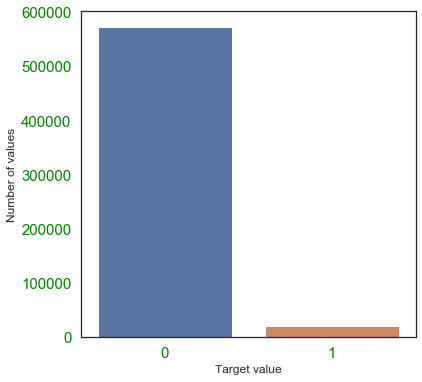

In [13]:
# Target variable 확인.
# 타이타닉에서도 했었음. 0과 1이 적절하게 섞여있는지, 균형이 안맞으면 조치가 필요하기 때문에. 
plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# Bar plot
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=15, labelcolor='green') # tick 에 관한 설정 가능.
plt.show()

.values : 딕셔너리 자료형 생성
Value만 얻고 싶다면 values 함수를 사용하면 된다. values 함수를 호출하면 dict_values 객체를 돌려줌.
Key-Value 관련 내용.
.keys() : key값 / items() : key, value 쌍 얻기

plt.tick_parmas()
< Parameters >
axis='x or y or both' , which axis to apply the parameters to. default both
reset=True/False , if True set all parameters to defaults. default False
which='major or minor or both' , apply arguments to which ticks. default major
length, width , tick length and width
color , tick color
labelsize , Tick label font size in points or as a string
labelcolor
pad , Distance in points between tick and label
labelrotaion , Tick label rotation (회전)

In [14]:
trainset.shape

(595212, 59)

In [15]:
trainset['target'].value_counts()[1]

21694

In [26]:
trainset.groupby(by='target')['id'].count()[1]

21694

In [19]:
print('Target variable ratio', (trainset['target'].value_counts()[1] / len(trainset))*100, '%')
# 너무 코드가 지저분함. 깔금하게 정리. 정규표현식을 이용하면 좋을 것 같음.
# trainset['target'].value_counts()[1] 말고 더 짧은 걸로 없을까

Target variable ratio 3.6447517859182947 %


In [20]:
print('Target Variable Ratio : {:.2f}%'.format(100*(trainset['target'].value_counts()[1]/trainset.shape[0])))

Target Variable Ratio : 3.64%


In [65]:
print('Target Variable Ration : {:.2f}%'.format((trainset['target']==1).sum()/trainset.shape[0]*100))

Target Variable Ration : 3.64%


In [27]:
# Real features
variable = metadata[(metadata.type=='real') & (metadata.preserve)].index
variable

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object', name='varname')

In [30]:
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [33]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [34]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

pow(x, y[,z]) : Return x to the power y
2 ** 3 = 8
pow(2,3) = 8
pow(100, 2) = 10000
pow(100, -2) = 0.0001
pow(2, 3, 3) = 2의 3승을 3으로 나눈 나머지

Features with missing values
ps_reg_o3, ps_car_12, ps_car_14 have missing values (their minimum value is -1)

Registration features
ps_reg_01 and ps_reg_02 are fractions with denominator 10 (values of 0.1, 0.2, 0.3 )

Car features
ps_car_12 are (with some approximations) square roots (divided by 10) of natural numbers whilst ps_car_15 are square roots of natural numbers. Let's represent the values using pairplot.

ps_car_12 와 ps_car_15 을 왜 따로 주목하는지 모르겠음.

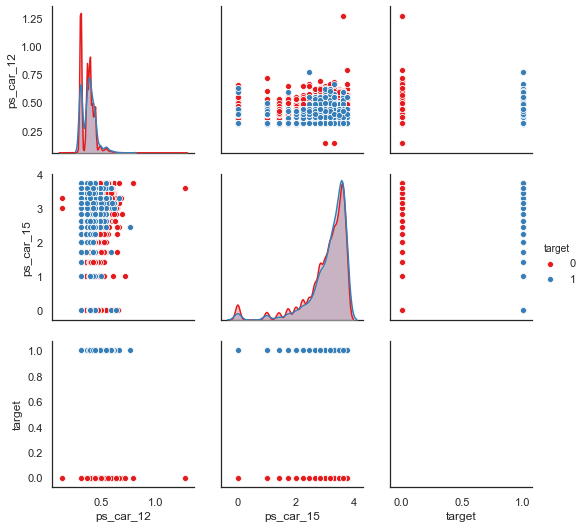

In [35]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

seaborn.pairplot(data, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, dropna=True, plot_kws=None, diag_kws=None, grid_kws=None, size=None)

data : DataFrame
hue : string, Variable in data to map plot aspects to different colors.
kind : {scatter, reg}, kind of plot for the non-identity relationship
diag_kind : {auto, hist, kde}, kind of plot the diagonal subplots.(대각선에 뭐 올지)

<Figure size 432x288 with 0 Axes>

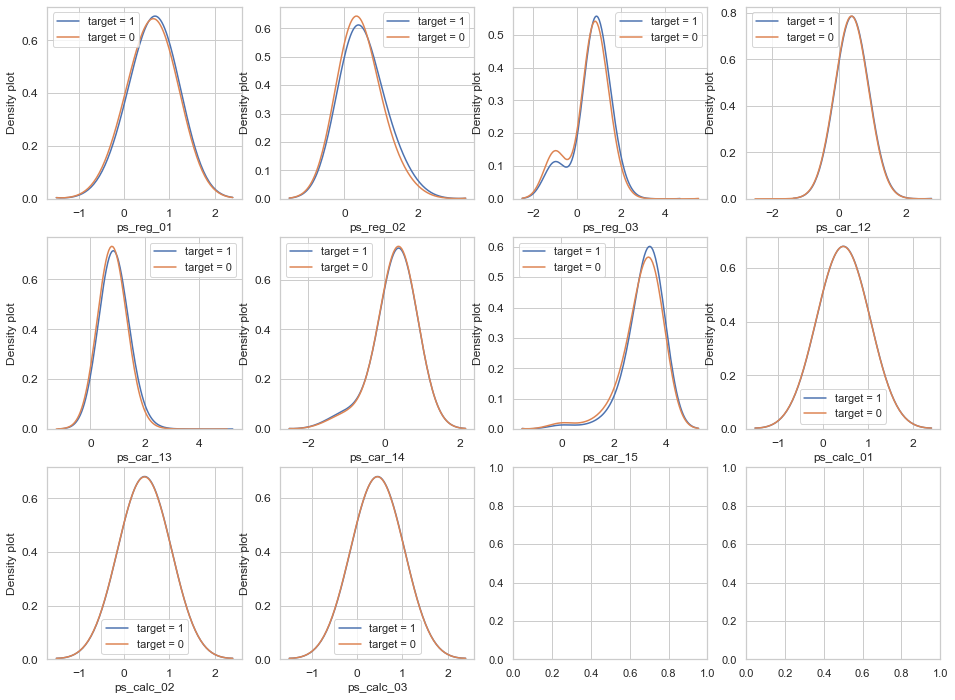

In [42]:
# Calculated features
# calc feature 들은 매우 유사한 분포를 서로 가지고 있음. 셋 다 비슷한 분포
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# kdeplot 의 bw 파라메타가 커지면 y축 숫자가 작아짐. 그래프가 조금 작아지는 것 같음.
# bw 가 그래프의 높이? 와 관련이 있는 것 같음.

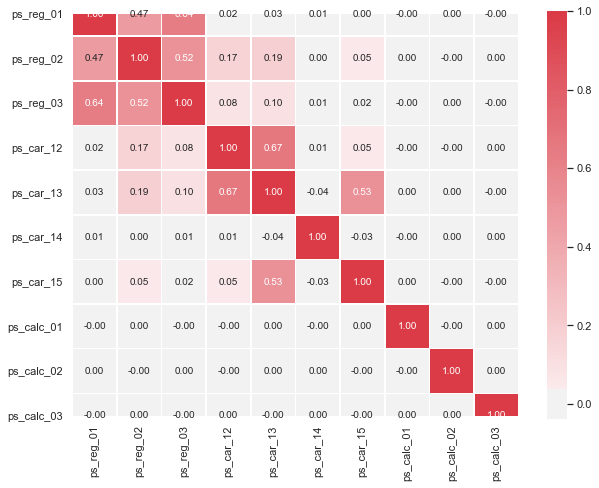

In [43]:
# visualize the correlation between the real feature
def corr_heatmap(var):
    correlations = trainset[var].corr()
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center = 0, fmt='.2f', 
               square=True, linewidths = .5, annot=True, cbar_kws={'shrink':.75})
    plt.show()
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

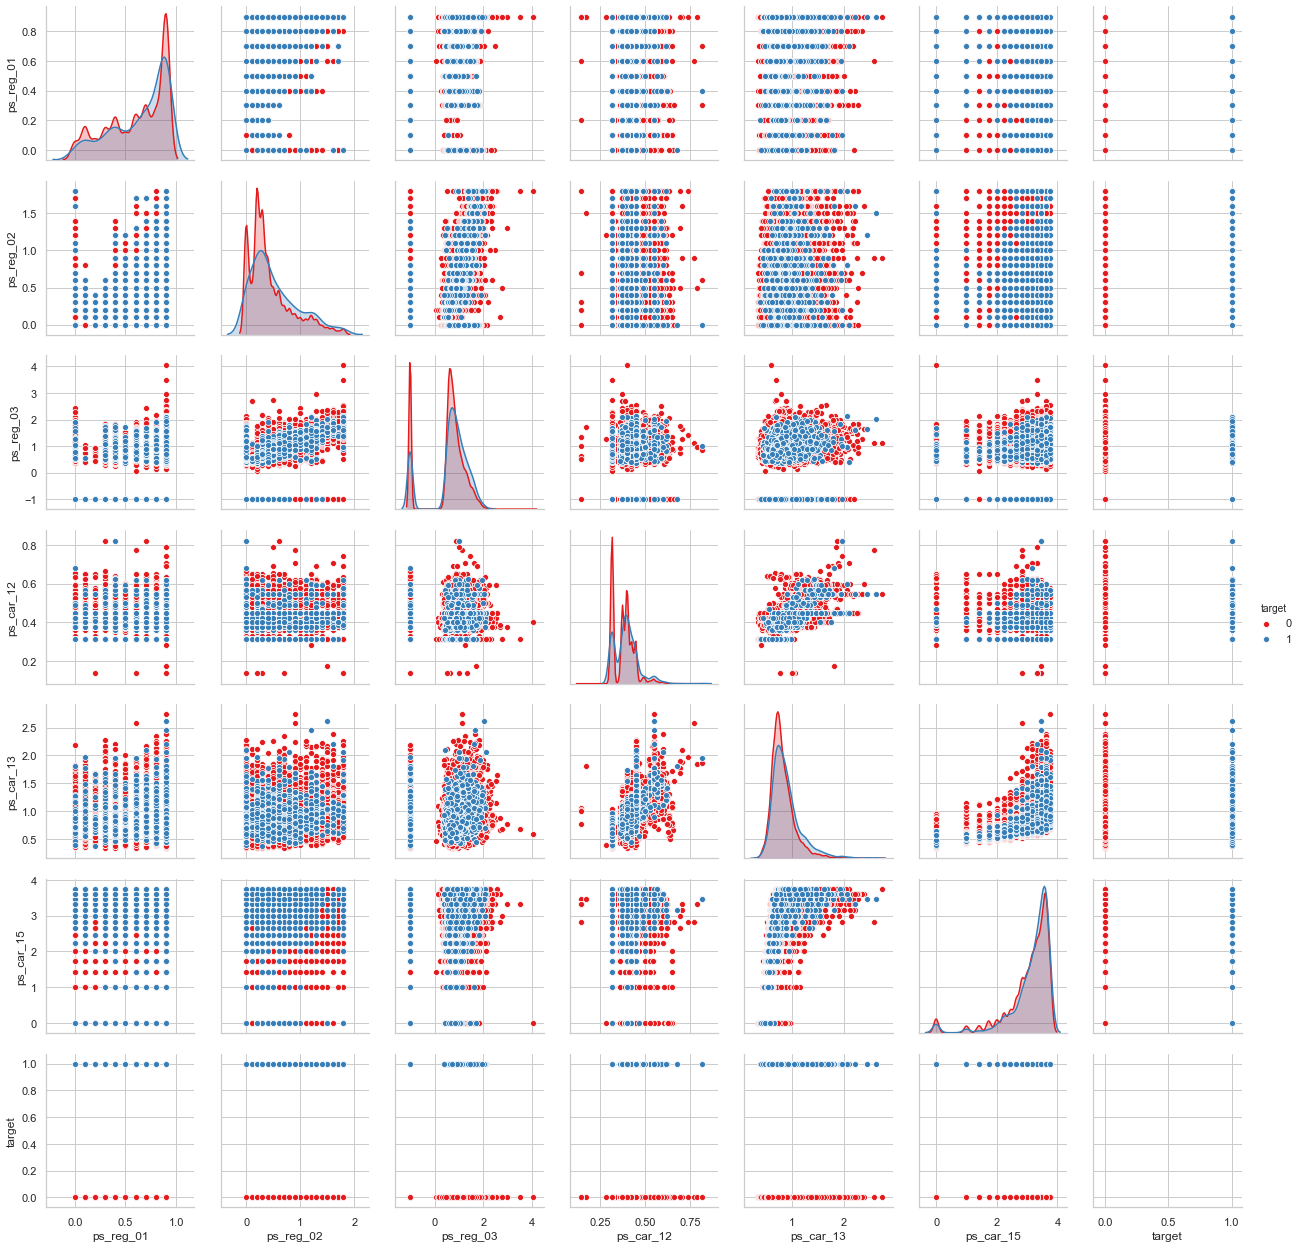

In [48]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

In [49]:
# Binary Classification
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
bin_col = [col for col in trainset.columns if '_bin' in col] # _bin 이 들어간 column name 추출하는 방법 
bin_col

['ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin']

In [55]:
ind_col = [i for i in trainset.columns if '_ind' in i]
ind_col

['ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

In [60]:
(trainset['target']==0).sum()

573518

<Figure size 432x288 with 0 Axes>

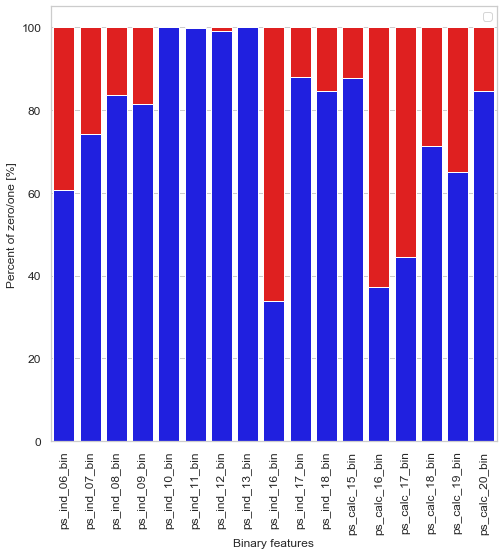

In [73]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100) # 0인 값들
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100) # 1인 값들
    # binary data 니까 0 하고 1 밖에 없음.
plt.figure()
fig, ax = plt.subplots(figsize=(8,8))
# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red')
# bottom 을 설정하면 하나의 면에 같은 x축을 쓸 수 있음.
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1,p2), ('Zero', 'One'))
plt.show();

seaborn.barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean>, ci=95, n_boot=1000, units=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)  

ci : size of confidence intervals  
bottom 을 쓰면 하나의 ax 에 같은 x축을 사용할 수 있음. 하나의 막대 위에 다른 것을 쌓을 때 사용  
plt.setp : '그래프 선 설정'이라고 나오는데, 여기서는 labels 가 xticks 로 설정되었으니까 setp(labels, ) 하면 xticks 가 변할거고 rotation 회전 옵션을 달았으므로 xticks가 회전하게 되는 것 같음.  
plt.tick_params 는 tick 의 파라메타를 변경하는 함수이고 axis 는 x축인지 y축인지 아니면 둘 다 인지 정하는 것. which 는 사이즈에 관련된 것인데 minor 랑 뭐가 있음. 신경 안써도 됨.  

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin and ps_ind_13_bin have very small number of values 1 (lesss than 0.5%) whilst the number of value 1 is very large for ps_ind_16_bin and ps_cals_16_bin (more than 60%)  

1의 비율이 0에 비해서 아주 없는 변수도 있고 높은 변수도 있고 그럼.    
이런 걸 왜 보고 있느냐 -> 1과 0 에서 어떤 변수를 써야 0과 1의 차이를 잘 잡아낼 수 있을 지 알기 위해서?    
0 일때의 feature 의 분포와 1 일때의 feature 의 분포를 왜 보고 있는 것인지 이유는?    

1. 변수 자체의 분포만 가지고 변수를 제거할 수는 없음. target 이 0 일때 x1의 분포가 target 이 1 일때 x1의 분포와 같아서 x1 이 target 을 잘 구분해낼 수 없는 변수이다 라고 판단하고 삭제? -> X 안된다. (변수들 간의 교호작용이 있을 수 있기 때문에)
2. x1과 x2와 x3 의 분포가 같다고 해서 차원축소를 위해 셋 중에 하나만 남기고 삭제해도 괜찮을까? -> 역시 안된다. X -> 다른 변수와 교호작용이 있을 수 있기 때문에
3. 결국 이 kernel 에서 kdeplot 을 그린 이유는 그냥 0과 1일 때 변수의 분포를 보기 위함. (단순하게 생각하면)
4. 차원을 축소하기 위해서는 차원축소를 위한 다른 방법을 적용해야한다. 그림만 보고 판단해서 삭제할 수는 없음.
5. 내가 생각한게 맞나? 그래서 앞선 kernel 에서 교호작용에 대한 변수를 만든건가?

<Figure size 432x288 with 0 Axes>

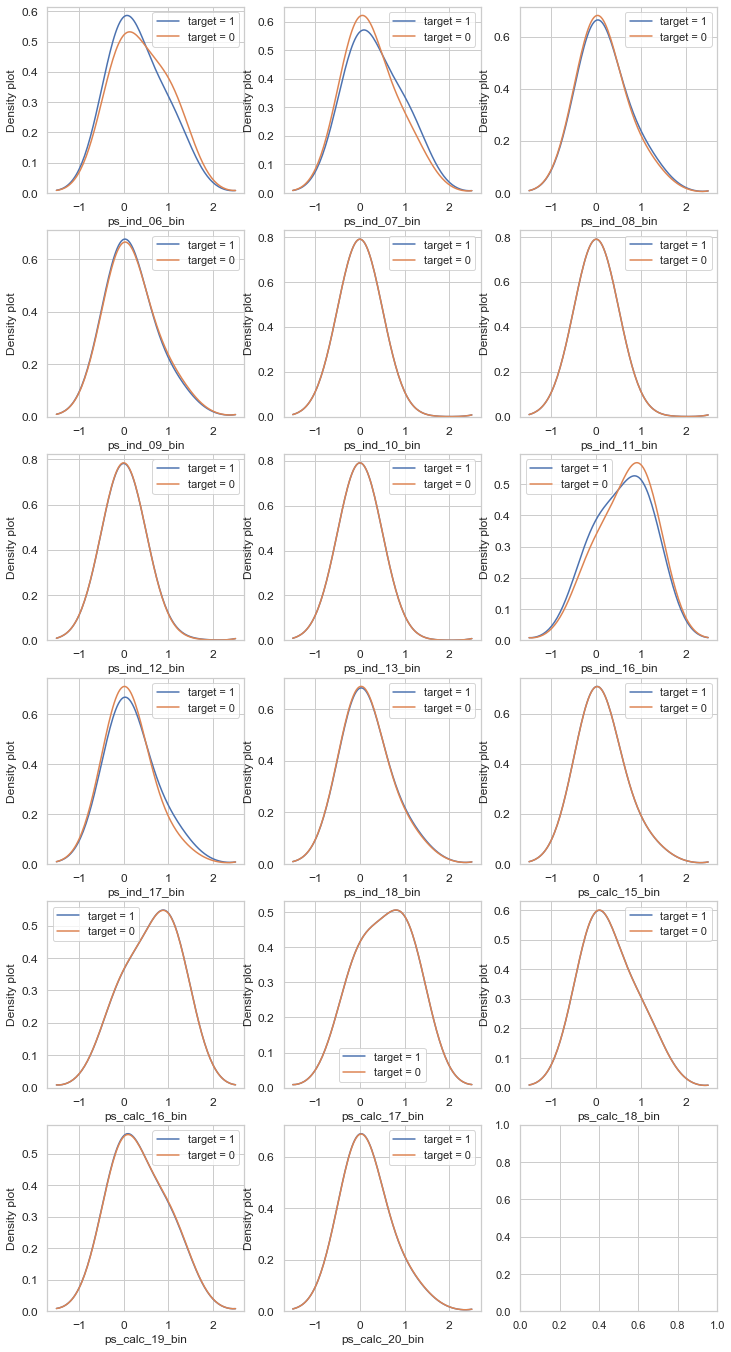

In [74]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()  # locs 는 없는데 왜 적어주는걸까?
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

density plot 이 balance 를 맞추는 것이 좋은것인가?  
inbalance 한 변수가 0과 1을 찾아내는데 더 적합?  
inbalance 와 balance 의 차이를 왜 그려서 보는 것인지 이유?

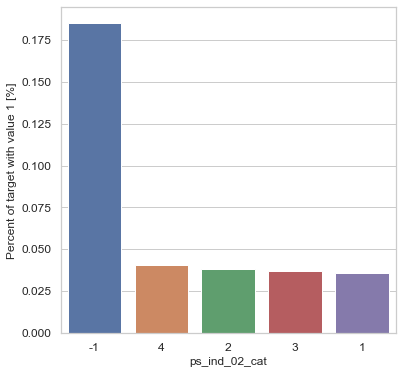

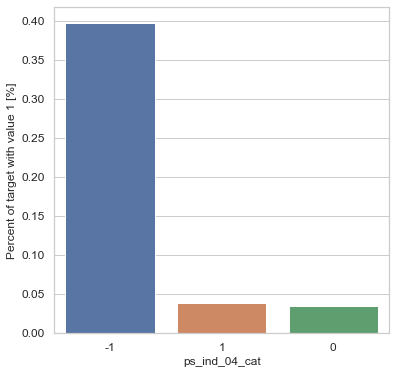

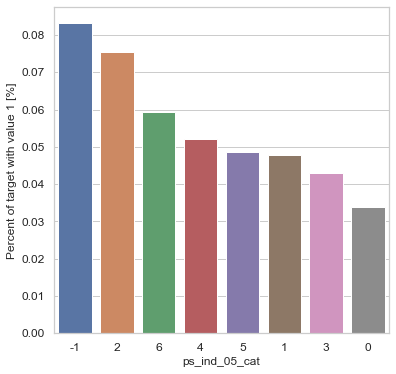

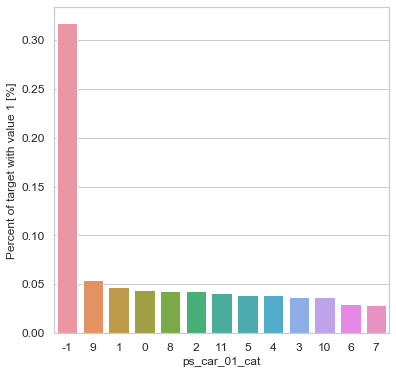

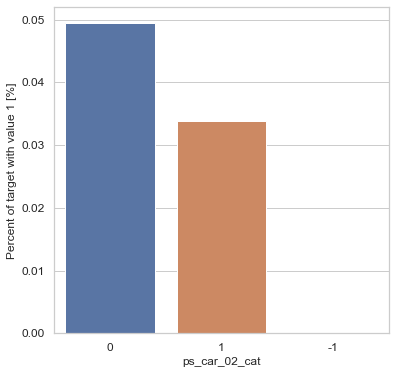

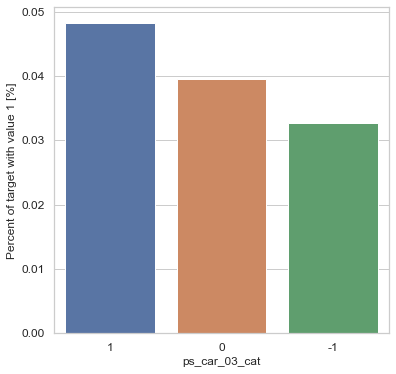

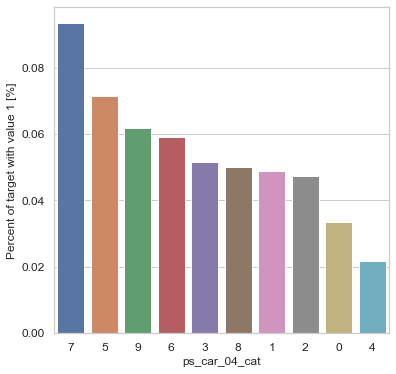

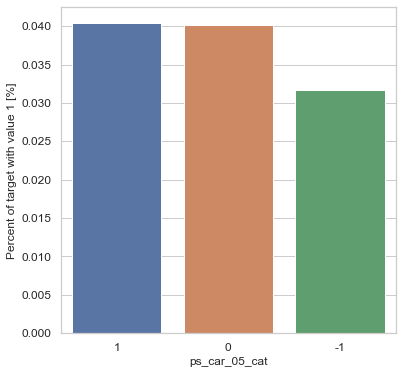

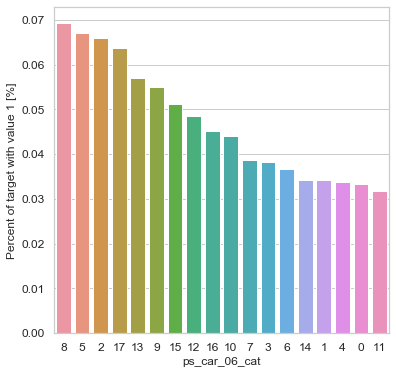

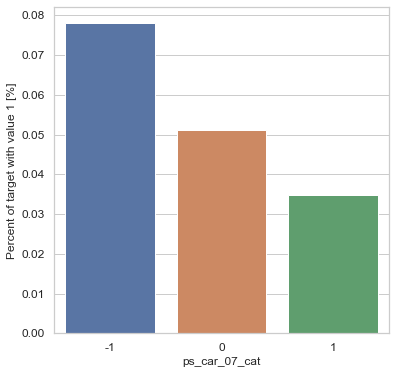

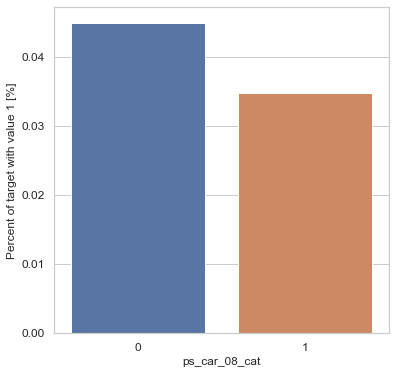

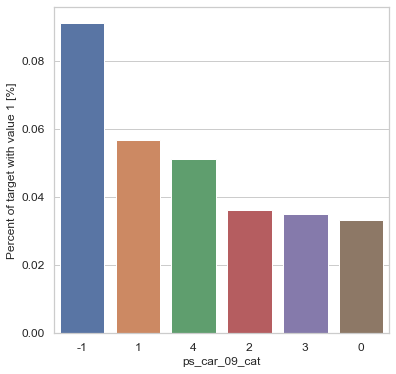

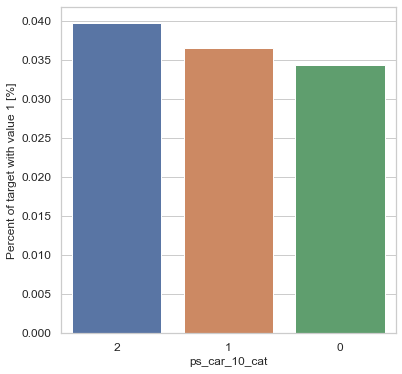

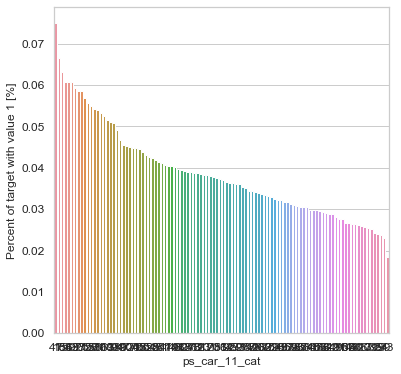

In [101]:
# Cartegorical features
# bar plot
var = metadata[(metadata.type == 'categorical') & metadata.preserve].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # Calculate the percentage of target=1 per category value
    cat_perc =trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # bar plot
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major',labelsize=12) # which 있으나 없으나 큰 변화는 없음.
    plt.show();

In [89]:
trainset[['ps_ind_02_cat', 'target']].groupby('ps_ind_02_cat', as_index=False).mean()

,ps_ind_02_cat,target
0,-1,0.185185
1,1,0.035725
2,2,0.038139
3,3,0.037217
4,4,0.040780


<Figure size 432x288 with 0 Axes>

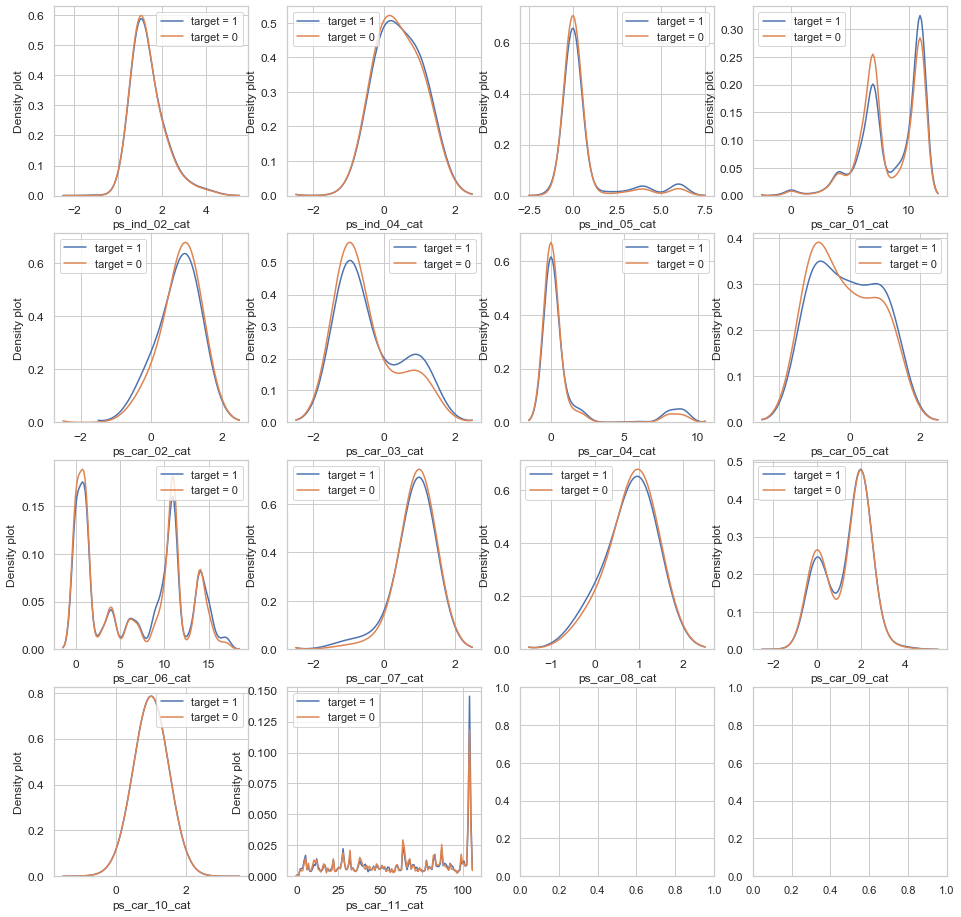

In [102]:
# categorical data
# use kdeplot
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

# 매번 sns.set_style 안해도 한번 지정하면 계속 적용된다.
plt.figure()
fit, ax = plt.subplots(4, 4, figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

inbalance 와 balance 의 기준이 없음. 그냥 kernel 작성자 마음대로 설정
왜 그렸는지도 잘 모르겠음.

<Figure size 432x288 with 0 Axes>

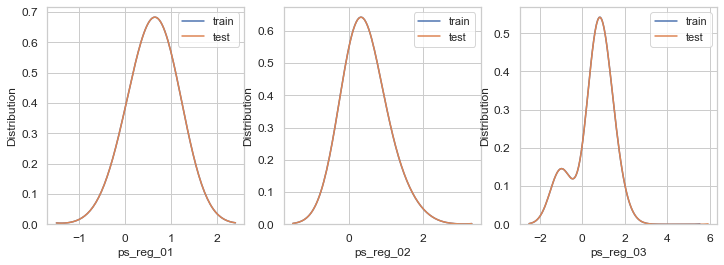

In [109]:
# Data unbalance between train, test
# 학습데이터와 테스트 데이터의 불균형 확인. -> 분포가 잘 맞아야 모델 적용할 수 있음.
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# bar plot
plt.figure()
fig, ax = plt.subplots(1,3, figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

<Figure size 432x288 with 0 Axes>

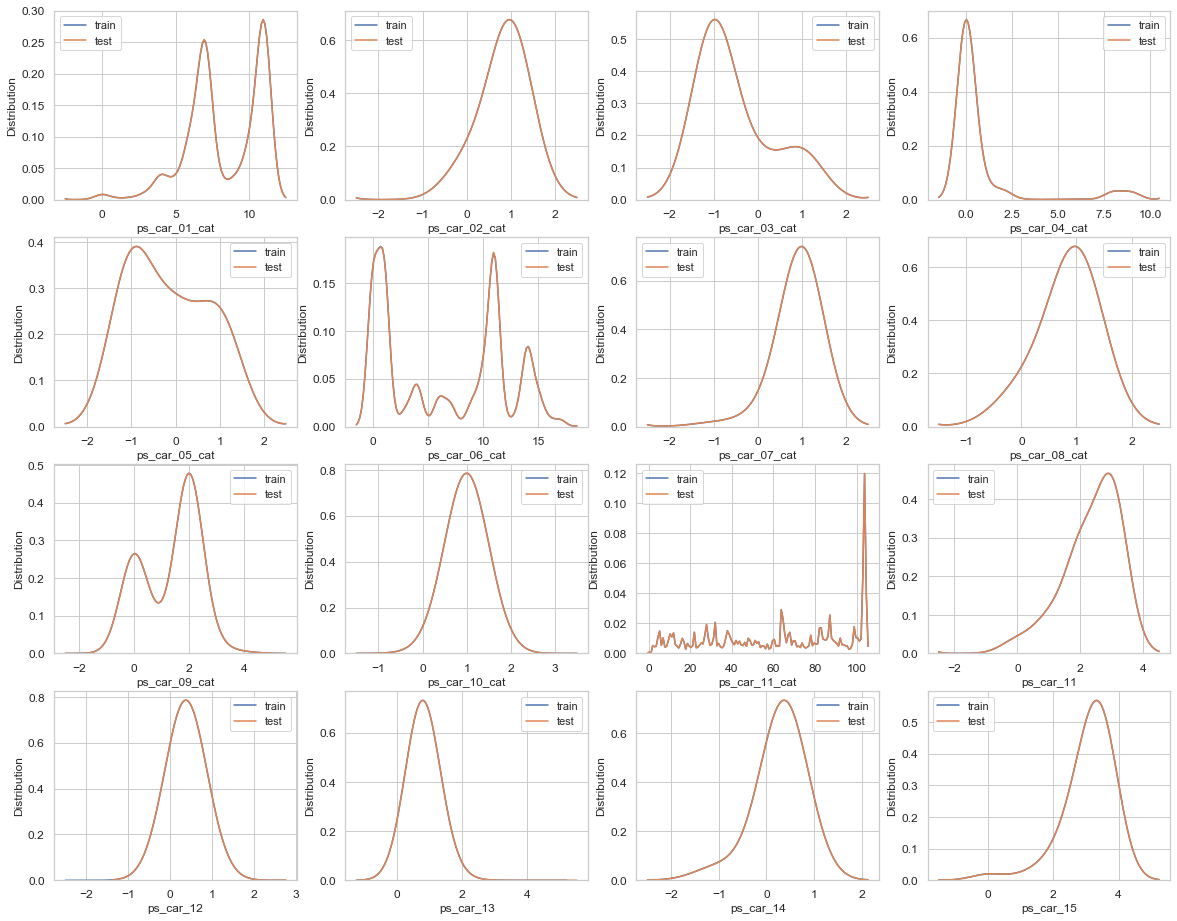

In [111]:
var = metadata[(metadata.category == 'car') & metadata.preserve].index

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()